### Setup & Dataset (MNIST)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [01:38<00:00, 101kB/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 83.2kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:17<00:00, 92.2kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 57.6kB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### CNN Model (CNN-1)

In [2]:
class CNN(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super(CNN, self).__init__()

        self.activation = activation()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x


### MLP Model

In [3]:
class MLP(nn.Module):
    def __init__(self, layers, use_bn=True):
        super(MLP, self).__init__()

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        input_size = 784

        for units in layers:
            self.layers.append(nn.Linear(input_size, units))
            if use_bn:
                self.bn_layers.append(nn.BatchNorm1d(units))
            input_size = units

        self.output = nn.Linear(input_size, 10)
        self.use_bn = use_bn
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_bn:
                x = self.bn_layers[i](x)
            x = self.relu(x)

        x = self.output(x)
        return x


### Training & Testing Functions


In [5]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

    acc = 100. * correct / len(loader.dataset)
    return total_loss / len(loader), acc


def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    acc = 100. * correct / len(loader.dataset)
    return total_loss / len(loader), acc


### CNN-1 Training (Adam, 10 Epochs)

In [6]:
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_acc = []
cnn_test_acc = []

for epoch in range(10):
    train_loss, train_acc = train(cnn_model, train_loader, optimizer, criterion)
    test_loss, test_acc = test(cnn_model, test_loader, criterion)

    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")


Epoch 1: Train Acc=95.65%, Test Acc=98.38%
Epoch 2: Train Acc=98.64%, Test Acc=98.76%
Epoch 3: Train Acc=99.09%, Test Acc=98.96%
Epoch 4: Train Acc=99.32%, Test Acc=98.82%
Epoch 5: Train Acc=99.53%, Test Acc=99.01%
Epoch 6: Train Acc=99.57%, Test Acc=99.01%
Epoch 7: Train Acc=99.66%, Test Acc=98.69%
Epoch 8: Train Acc=99.66%, Test Acc=98.94%
Epoch 9: Train Acc=99.69%, Test Acc=99.02%
Epoch 10: Train Acc=99.79%, Test Acc=99.03%


### MLP-1 (512-256-128, SGD, 20 Epochs)

In [7]:
mlp1 = MLP([512, 256, 128]).to(device)
optimizer = optim.SGD(mlp1.parameters(), lr=0.01, momentum=0.9)

mlp1_train_acc = []
mlp1_test_acc = []

for epoch in range(20):
    train_loss, train_acc = train(mlp1, train_loader, optimizer, criterion)
    test_loss, test_acc = test(mlp1, test_loader, criterion)

    mlp1_train_acc.append(train_acc)
    mlp1_test_acc.append(test_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")


Epoch 1: Train Acc=93.58%, Test Acc=97.45%
Epoch 2: Train Acc=98.04%, Test Acc=97.62%
Epoch 3: Train Acc=98.81%, Test Acc=97.94%
Epoch 4: Train Acc=99.25%, Test Acc=97.85%
Epoch 5: Train Acc=99.58%, Test Acc=98.15%
Epoch 6: Train Acc=99.64%, Test Acc=98.26%
Epoch 7: Train Acc=99.78%, Test Acc=98.31%
Epoch 8: Train Acc=99.84%, Test Acc=98.30%
Epoch 9: Train Acc=99.89%, Test Acc=98.22%
Epoch 10: Train Acc=99.91%, Test Acc=98.21%
Epoch 11: Train Acc=99.95%, Test Acc=98.38%
Epoch 12: Train Acc=99.96%, Test Acc=98.30%
Epoch 13: Train Acc=99.96%, Test Acc=98.39%
Epoch 14: Train Acc=99.99%, Test Acc=98.38%
Epoch 15: Train Acc=99.97%, Test Acc=98.40%
Epoch 16: Train Acc=99.94%, Test Acc=98.34%
Epoch 17: Train Acc=99.97%, Test Acc=98.33%
Epoch 18: Train Acc=99.98%, Test Acc=98.42%
Epoch 19: Train Acc=99.99%, Test Acc=98.35%
Epoch 20: Train Acc=99.99%, Test Acc=98.50%


### MLP-2 (256, Adam, 15 Epochs)

In [8]:
mlp2 = MLP([256]).to(device)
optimizer = optim.Adam(mlp2.parameters(), lr=0.001)

mlp2_train_acc = []
mlp2_test_acc = []

for epoch in range(15):
    train_loss, train_acc = train(mlp2, train_loader, optimizer, criterion)
    test_loss, test_acc = test(mlp2, test_loader, criterion)

    mlp2_train_acc.append(train_acc)
    mlp2_test_acc.append(test_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")


Epoch 1: Train Acc=93.03%, Test Acc=96.46%
Epoch 2: Train Acc=96.88%, Test Acc=97.36%
Epoch 3: Train Acc=97.92%, Test Acc=97.74%
Epoch 4: Train Acc=98.49%, Test Acc=97.95%
Epoch 5: Train Acc=98.82%, Test Acc=98.04%
Epoch 6: Train Acc=99.19%, Test Acc=97.93%
Epoch 7: Train Acc=99.33%, Test Acc=97.54%
Epoch 8: Train Acc=99.52%, Test Acc=97.79%
Epoch 9: Train Acc=99.56%, Test Acc=97.52%
Epoch 10: Train Acc=99.62%, Test Acc=97.92%
Epoch 11: Train Acc=99.72%, Test Acc=98.00%
Epoch 12: Train Acc=99.74%, Test Acc=97.88%
Epoch 13: Train Acc=99.64%, Test Acc=97.82%
Epoch 14: Train Acc=99.78%, Test Acc=98.02%
Epoch 15: Train Acc=99.79%, Test Acc=97.91%


### Accuracy Plot

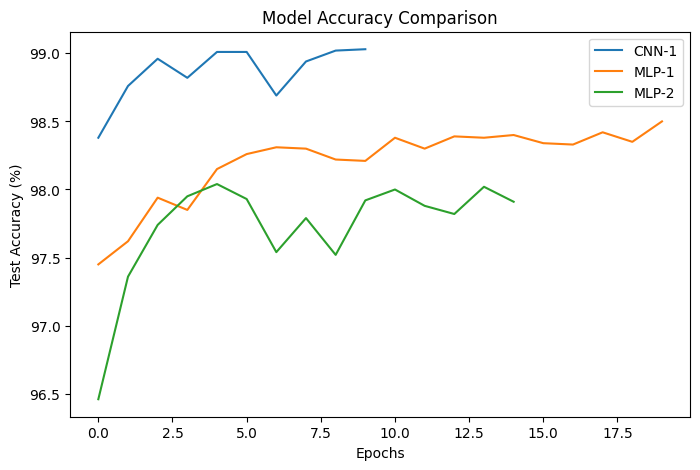

In [9]:
plt.figure(figsize=(8,5))

plt.plot(cnn_test_acc, label="CNN-1")
plt.plot(mlp1_test_acc, label="MLP-1")
plt.plot(mlp2_test_acc, label="MLP-2")

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.legend()
plt.show()
